In [1]:
import numpy as np #rename the library to np for convenience
import matplotlib.pyplot as plt #we want the "pyplot" module
import math
#allows plots to display in the notebook instead of another window
%matplotlib inline
print('Libraries successfully imported!')

Libraries successfully imported!


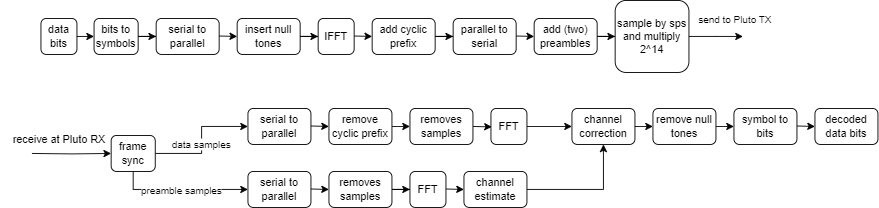

In [2]:
# set up OFDM subcarriers 
N = 64 # total number of OFDM subcarriers (data and null carriers)
CP_length = 8 #length of cyclic prefix

#define which carriers transmit null tones and which contains payload
allCarriers = np.arange(N) #indices of all subcarriers ([0,1,...,N-1])
nullCarriers = [0,30,30,30] #indices of all null carriers, error in later steps --> this will give nullCarriers = [0,31,32,33]

K = len(nullCarriers) # number of null subcarriers
dataCarriers = np.delete(allCarriers, [0,31,32,33]) #indices of all data carriers 
print("There are ", len(allCarriers), " total carriers with", len(dataCarriers), "data carriers and ", len(nullCarriers), " null carriers")
print("Null Carriers are ", [0,31,32,33])
print("Data Carriers are ", dataCarriers)


There are  64  total carriers with 60 data carriers and  4  null carriers
Null Carriers are  [0, 31, 32, 33]
Data Carriers are  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 59 60 61 62 63]


Modulation type: sixteen_QAM 
number of bits per symbol: 4 
number of payload bits per OFDM symbol: 240


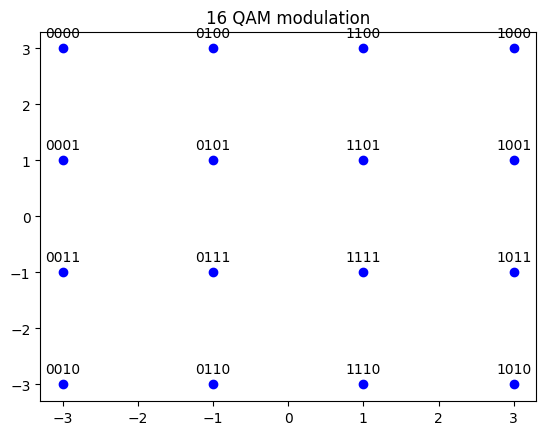

In [3]:
# set up modulation type
modulationType = "sixteen_QAM" #change to either four_QAM or sixteen_QAM - ONLY CHANGE THIS LINE!!!


# 4 QAM
def four_QAM():
    mu = 2 # number of bits per symbol 
    payloadBits_per_OFDM = len(dataCarriers)*mu # number of payload bits per OFDM symbol
    mapping_table = {
        (0,0): 1+1j,
        (0,1): -1+1j,
        (1,0): -1-1j,
        (1,1): 1-1j
    }

    for b1 in [0, 1]:
        for b0 in [0, 1]:
            B = (b1, b0)
            Q = mapping_table[B]
            plt.title("4 QAM modulation")
            plt.plot(Q.real, Q.imag, 'bo')
            plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')
    return mu, payloadBits_per_OFDM, mapping_table
    
# 16 QAM
def sixteen_QAM():
    mu = 4 # number of bits per symbol 
    payloadBits_per_OFDM = len(dataCarriers)*mu # number of payload bits per OFDM symbol
    mapping_table = {
        (0,0,0,0) : -3+3j,
        (0,0,0,1) : -3+1j,
        (0,0,1,0) : -3-3j,
        (0,0,1,1) : -3-1j,
        (0,1,0,0) : -1+3j,
        (0,1,0,1) : -1+1j,
        (0,1,1,0) : -1-3j,
        (0,1,1,1) : -1-1j,
        (1,0,0,0) :  3+3j,
        (1,0,0,1) :  3+1j,
        (1,0,1,0) :  3-3j,
        (1,0,1,1) :  3-1j,
        (1,1,0,0) :  1+3j,
        (1,1,0,1) :  1+1j,
        (1,1,1,0) :  1-3j,
        (1,1,1,1) :  1-1j
    }
    for b3 in [0, 1]:
        for b2 in [0, 1]:
            for b1 in [0, 1]:
                for b0 in [0, 1]:
                    B = (b3, b2, b1, b0)
                    Q = mapping_table[B]
                    plt.title("16 QAM modulation")
                    plt.plot(Q.real, Q.imag, 'bo')
                    plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')
    return mu, payloadBits_per_OFDM, mapping_table

if modulationType == "four_QAM":
    mu, payloadBits_per_OFDM, mapping_table = four_QAM()

elif modulationType == "sixteen_QAM":
    mu, payloadBits_per_OFDM, mapping_table = sixteen_QAM()

else:
    print("invalid modulation type")

print("Modulation type:", modulationType, "\nnumber of bits per symbol: "+str(mu)+" \nnumber of payload bits per OFDM symbol: "+str(payloadBits_per_OFDM))
demapping_table = {v: k for k, v in mapping_table.items()} #used for demapping later on 

In [4]:

# set up random bit sequence
num_packets = 1 #number of OFDM packets to be transmitted
bits = np.random.randint(0, 2, size=(num_packets*payloadBits_per_OFDM)) # how many bits to be transmitted
print("bits = ", bits)
print("length of bits = ", len(bits))



# convert to symbol, x-QAM modulation scheme
def SP(bits):
    return bits.reshape(len(bits)//mu, mu)
bits_SP = SP(bits)

def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])
QAM = Mapping(bits_SP)

print("QAM = ", QAM)



# convert serial to parallel 
def s_to_p(QAM):
    rows = (math.ceil(len(QAM)/len(dataCarriers)))
    cols = (len(dataCarriers))
    arr_sizes = rows * cols
    
    QAM_sp = np.pad(QAM, pad_width = (0,arr_sizes - len(QAM)))
    return rows, cols, QAM_sp.reshape(rows, cols)

rows, cols, QAM_reshaped = s_to_p(QAM) 
print("rows = ", rows)
print("cols (before inserting null tone) = ", cols)



#insert null tones
OFDM_data = np.zeros((rows, N), dtype=complex)
OFDM_data = np.insert(QAM_reshaped, nullCarriers, 0, axis=1)
print(OFDM_data)


print("after inserting null tone", np.shape(OFDM_data))
cols = len(OFDM_data[0]) # new # of columns should equal N
print("new # of columns ", cols)

#exceptions
if len(OFDM_data[0]) != N:
    raise Exception("Error converting serial to parallel. Check that the amount of bits transmitted is an integer multiple of the amount of bits in an OFDM packet", N)

#########################################

#create OFDM preamble
pre = np.random.randint(0, 2, size=(payloadBits_per_OFDM)) #preamble is 1 packet long
pre_SP = SP(pre)
pre_QAM = Mapping(pre_SP)



#insert null tones to preamble
OFDM_preamble = np.insert(pre_QAM, nullCarriers, 0)

print("pream with null tones:", OFDM_preamble)


bits =  [0 1 1 0 0 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 1 1 1 1 0 1 0 1 1 0 0 0
 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 1 1 0 0
 1 1 1 1 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 1 0 1
 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 1 1 0 1 0 1 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 1
 0 1 1 1 1 0 0 0 1 0 0 0 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 1 0 1 1 0 1
 1 1 0 0 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 1 0 1 1 1 1 0 1
 1 0 1 1 0 0 0 1 0 1 0 0 0 0 0 1 1 1]
length of bits =  240
QAM =  [-1.-3.j -3.+3.j  3.-3.j -1.+1.j  3.-3.j -3.+1.j -1.-1.j  3.-3.j  1.+3.j
 -1.-1.j  3.-1.j  1.-3.j -3.-1.j -1.+3.j -3.+1.j -1.+1.j -3.-3.j -3.-1.j
 -3.-1.j  1.+3.j  3.-1.j -3.+1.j -1.-1.j -3.-1.j -3.-3.j  3.+1.j -1.+3.j
  3.-3.j -3.+3.j -1.+1.j  1.+3.j  3.-1.j -1.+1.j  1.-1.j -3.+3.j -1.-3.j
 -3.+1.j -1.-1.j  3.+3.j  3.+3.j  1.+1.j -1.-3.j  3.+3.j -1.+1.j  1.+1.j
 -1.-3.j  1.-3.j -3.-1.j  1.+3.j  1.-1.j  3.-1.j  1.-1.j -3.+3.j -3.-3.j
  1.-1.j -1.-3.j  1.+3.j -1.+1.j -3.+

In [5]:
#IFFT (convert data and preamble to time domain)
OFDM_time = np.fft.ifft2(OFDM_data)
OFDM_preamble_time = np.fft.ifft(OFDM_preamble)
print ("Number of OFDM samples in time-domain before CP: ", len(OFDM_time))



cps = [] #keep track of the cyclic prefixes of each data packet
#add cyclic prefix to data 
def addCP(OFDM_time):
    OFDM_CP = np.zeros((rows, N+CP_length), dtype=complex)
    for i in range(rows):
        cp = OFDM_time[i][-CP_length:] #take the last "CP" amount of values
        cps.append(cp)
        OFDM_CP[i] = np.hstack([cp, OFDM_time[i]])
    return OFDM_CP, cp #put them in the front of array

print("added last ", CP_length, "elements to front of array for cyclic prefix")
OFDM_CP, cp = addCP(OFDM_time) 
print("cyclic prefix for data", cps)

#add cyclic prefix for preamble
preamble_cp = OFDM_preamble_time[-CP_length:]
OFDM_preamble_CP = np.append(preamble_cp, OFDM_preamble_time)


#parallel to serial
OFDM_CP_serial = OFDM_CP.flatten()

print(len(OFDM_CP[0]))
print(len(OFDM_CP_serial)) #now the two packets are serialized into one packet

#exceptions
if (len(OFDM_CP[0])*num_packets != len(OFDM_CP_serial)):
    raise Exception("Error converting parallel to serial. Check that the amount of bits transmitted is an integer multiple of the amount of bits in an OFDM packet", N)

Number of OFDM samples in time-domain before CP:  1
added last  8 elements to front of array for cyclic prefix
cyclic prefix for data [array([-0.65310922-0.30713835j, -0.04749582+0.16643089j,
        0.23182458+0.00890394j, -0.13225719+0.01792127j,
       -0.30489412+0.16573812j, -0.29170854-0.19907823j,
        0.07439417-0.13041158j, -0.13505485+0.04749849j])]
72
72


In [6]:
# append TWO preambles to the data packets (we use TWO preambles so we can average the noise later)
OFDM_w_preamble = np.concatenate((OFDM_preamble_CP, OFDM_preamble_CP, OFDM_CP_serial), 0)

print("length of OFDM_w_preamble", len(OFDM_w_preamble))

#exceptions
if len(OFDM_w_preamble) != (len(OFDM_preamble_CP)*2 + num_packets * (N+CP_length)):
    raise Exception("Error concatenating two preambles with data.")

length of OFDM_w_preamble 216


In [7]:
import adi

#Stop transmitting --> comment out if running for first time, uncomment for later 
# sdr.tx_destroy_buffer()

OFDM_TX = OFDM_w_preamble

#Config Pluto 
sps = 10 # sample per symbol (to create square pulse)
sample_rate = 1e6 # Hz
center_freq = 915e6 # Hz
num_samps = 4*sps*len(OFDM_TX) # number of samples per call to rx(), increase if exception after frame sync
sdr = adi.Pluto("ip:192.168.2.1")
sdr.sample_rate = int(sample_rate)

# Config Tx
sdr.tx_rf_bandwidth = int(sample_rate) # filter cutoff, just set it to the same as sample rate
sdr.tx_lo = int(center_freq)
sdr.tx_hardwaregain_chan0 = 0.0 #Increase to increase tx power, valid range is -90 to 0 dB

# Config Rx
sdr.rx_lo = int(center_freq)
sdr.rx_rf_bandwidth = int(sample_rate)
sdr.rx_buffer_size = int(num_samps)
sdr.gain_control_mode_chan0 = 'manual'
sdr.rx_hardwaregain_chan0 = 0.0 # dB, increase to increase the receive gain, but be careful not to saturate the ADC


# Transmit samples
sdr.tx_cyclic_buffer = True # Enable cyclic buffers
OFDM_TX = np.repeat(OFDM_TX, sps) #create square pulse, symbol --> sample
OFDM_TX_send = OFDM_TX* 2**14 # for transmitter range [-2e14,2e14]
sdr.tx(OFDM_TX_send) # start transmitting

# Clear buffer just to be safe
for i in range (0, 10):
    raw_data = sdr.rx()

# Receive samples
OFDM_RX = sdr.rx()


# print("TX", OFDM_TX[0:32])
# print("first RX", OFDM_RX[0:32])

# print("length of TX", len(OFDM_TX))
# print("length of RX", len(OFDM_RX))

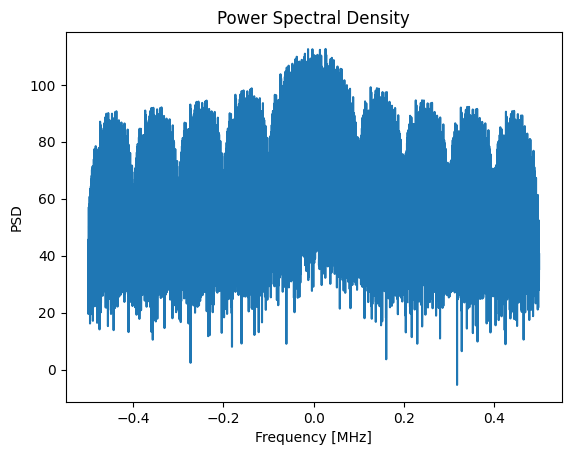

In [8]:
# Calculate power spectral density 
psd = np.abs(np.fft.fftshift(np.fft.fft(OFDM_RX)))**2
psd_dB = 10*np.log10(psd)
f = np.linspace(sample_rate/-2, sample_rate/2, len(psd))

# Plot freq domain
plt.figure(1)
plt.plot(f/int(sample_rate), psd_dB) #i changed 1e6 to sample_rate, idk if right
plt.xlabel("Frequency [MHz]")
plt.ylabel("PSD")
plt.title("Power Spectral Density")
plt.show()

In [9]:

# frame sync

two_preambles = np.append(OFDM_preamble_CP, OFDM_preamble_CP)
two_preambles = np.repeat(two_preambles, sps) #sample the preambles with sps
preamble_length = len(two_preambles) #put 2 preambles together 
print("two preamble length is", preamble_length)



# OLD FRAME SYNC (WORKS)
# def max_in_arr(arr, n):
#     # Initialize maximum element
#     max_elem = arr[0]
#     max_i = 0
#     # Traverse array elements from second
#     # and compare every element with
#     # current max
#     for i in range(1, n):
#         if np.linalg.norm(arr[i]) > np.linalg.norm(max_elem):
#             max_elem = arr[i]
#             max_i = i 
#     return max_elem, max_i

# #correlate two preambles with received datas
# arr = []
# for i in range(len(OFDM_RX)):
#     arr.append(np.correlate(two_preambles, OFDM_RX[i:preamble_length+i]))
    
# flat_arr =[]
# for i in range(len(arr)):
#     flat_arr.extend(arr[i])

# # find the maximum correlation
# max_corr, k = max_in_arr(flat_arr, len(flat_arr))
# print("k is ", k)

#NEW FRAME SYNC
def max_in_arr(arr, n):
    # Initialize maximum element
    max_elem = arr[0]
    max_i = 0
    # Traverse array elements from second
    # and compare every element with
    # current max
    for i in range(1, n):
        if np.linalg.norm(arr[i]) > np.linalg.norm(max_elem):
            max_elem = arr[i]
            max_i = i 
    return max_elem, max_i

#correlate two preambles with received datas
arr = []
for i in range(int(np.floor(len(OFDM_RX)/2))): #set limitation to frame sync idk maybe this will help 
    arr.append(np.correlate(two_preambles, OFDM_RX[i:preamble_length+i]))
# print("arr length", len(arr))
flat_arr =[]
for i in range(len(arr)):
    flat_arr.extend(arr[i])

# find the maximum correlation
max_corr, k = max_in_arr(arr, len(arr))
# print("k is ", k)


#shift received datas to align with frame sync
OFDM_RX_shifted = OFDM_RX[k:len(OFDM_RX)+k]

print("length of OFDM_RX_shifted", len(OFDM_RX_shifted))

#exceptions --> this will be the most common, because it completely depends on the channel 
if len(OFDM_RX_shifted) < (preamble_length+(num_packets*(N+CP_length)*sps)):
    raise Exception("Not enough data captured to decode. Increase num_samps")
    

two preamble length is 1440
length of OFDM_RX_shifted 5619


In [10]:

# channel estimation

# average noise using both preambles
one_preamble_length = preamble_length // 2
first_preamble = OFDM_RX_shifted[0:one_preamble_length]
second_preamble = OFDM_RX_shifted[one_preamble_length:preamble_length]

print("first preamble length", len(first_preamble))
print("second preamble length", len(second_preamble))

OFDM_RX_preambles = (first_preamble + second_preamble) / 2
print(np.shape(OFDM_RX_preambles))


OFDM_preamble_sample = np.repeat(OFDM_preamble_CP, sps)
print("original preamble in time", OFDM_preamble_sample[0:10])
print("received preamble in time", OFDM_RX_preambles[0:10])

#exceptions
if len(OFDM_preamble_sample) != len(OFDM_RX_preambles):
    raise Exception("Original preamble length is not equal to Received preamble length. Check previous exception")

# remove cyclic prefix from preamble
OFDM_RX_preambles = OFDM_RX_preambles[CP_length*sps:]
print(np.shape(OFDM_RX_preambles))

# change samples back to symbols using slice
OFDM_RX_preambles = OFDM_RX_preambles[::sps]
print("after removing sps", np.shape(OFDM_RX_preambles))


#FFT preambles (time->frequency)
OFDM_preamble_original = np.fft.fft(OFDM_preamble_time)
OFDM_preamble_received = np.fft.fft(OFDM_RX_preambles)
            
print("original preamble in freq", OFDM_preamble_original[0:10])
print("received preamble in freq", OFDM_preamble_received[0:10])

#estimate the channel
Hest = OFDM_preamble_received / OFDM_preamble_original
print("Hest", Hest[0:10])

#exception
if len(Hest) != N:
    raise Exception("Length of Hest is not equal to OFDM packet length N. Check previous exception")


# IFFT to time domain
# 

first preamble length 720
second preamble length 720
(720,)
original preamble in time [-0.24842961-0.04576457j -0.24842961-0.04576457j -0.24842961-0.04576457j
 -0.24842961-0.04576457j -0.24842961-0.04576457j -0.24842961-0.04576457j
 -0.24842961-0.04576457j -0.24842961-0.04576457j -0.24842961-0.04576457j
 -0.24842961-0.04576457j]
received preamble in time [-71. +196.j  -85.5+204.j  -72.5+199.j  -84. +201.5j -72.5+200.j
 -83. +201.5j -74. +200.j  -82. +200.j  -75. +201.j  -86. +198.5j]
(640,)
after removing sps (64,)
original preamble in freq [ 0.+1.66533454e-16j  3.-1.00000000e+00j  3.-3.00000000e+00j
  3.+3.00000000e+00j  3.+3.00000000e+00j  3.+3.00000000e+00j
  3.+1.00000000e+00j -3.-1.00000000e+00j -3.-3.00000000e+00j
 -3.+3.00000000e+00j]
received preamble in freq [ 1004.         -117.5j          -75.26848837-2421.83207317j
 -1897.43295671-2815.65569354j  2738.65464212-1987.40638659j
  2858.87238675-2164.81949612j  2808.01894875-1923.53692234j
  1410.70673299-2066.69667666j -1158.47

In [11]:
# channel correction

# take first fully received data packet
OFDM_RX_data_CP = OFDM_RX_shifted[preamble_length:preamble_length+(num_packets*len(OFDM_CP[0]))*sps]
print(np.shape(OFDM_RX_shifted))

# serial to parallel
OFDM_RX_data_reshape = OFDM_RX_data_CP.reshape(num_packets, (N+CP_length)*sps)
print(np.shape(OFDM_RX_data_reshape))


OFDM_RX_data = np.zeros((num_packets, N*sps), dtype = complex)
OFDM_RX_freq = np.zeros((num_packets, N), dtype = complex)
OFDM_RX_corr = np.zeros((num_packets, N), dtype = complex)

#remove cyclic prefix from received data 
for i in range(num_packets):
    OFDM_RX_data[i] = OFDM_RX_data_reshape[i][CP_length*sps:]


# change samples back to symbols using slice
OFDM_RX_data_no_sps = OFDM_RX_data[::,::sps]

# FFT data (time-->frequency)
OFDM_RX_freq = np.fft.fft2(OFDM_RX_data_no_sps)

# correct the channel
for i in range(num_packets):
    OFDM_RX_corr[i] = OFDM_RX_freq[i] / Hest



#remove null tones
OFDM_received_data = np.zeros((num_packets, N), dtype=complex)
OFDM_received_data = np.delete(OFDM_RX_corr, [0,31,32,33], axis=1)

# #check
# print("OFDM received data", OFDM_received_data)
# print("OFDM original data", QAM_reshaped)

(5619,)
(1, 720)


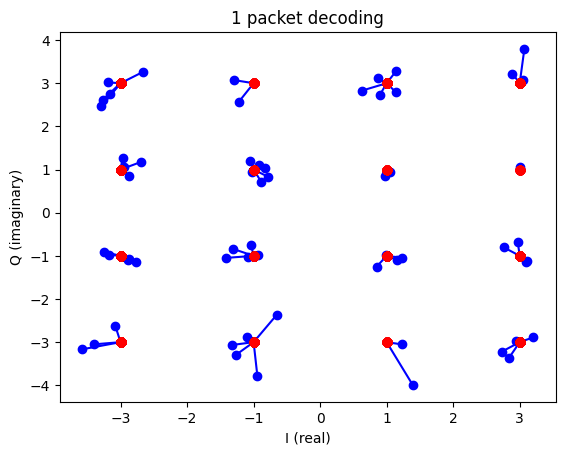

In [13]:
#use nearest neighbor decision to map received data to QAM constellation points

def Demapping(QAM):
    # array of possible constellation points
    constellation = np.array([x for x in demapping_table.keys()])
    
    # calculate distance of each RX point to each possible point
    dists = abs(QAM.reshape((-1,1)) - constellation.reshape((1,-1)))
    
    # for each element in QAM, choose the index in constellation 
    # that belongs to the nearest constellation point
    const_index = dists.argmin(axis=1)
    
    # get back the real constellation point
    hardDecision = constellation[const_index]
    
    # transform the constellation point into the bit groups
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision

for i in range(num_packets):
    PS_est, hardDecision = Demapping(OFDM_received_data)

hardDecision = hardDecision.reshape(num_packets,N-K)

for i in range(num_packets):
    plt.figure()
    for qam, hard in zip(OFDM_received_data[i], hardDecision[i]):
        plt.title(str(i+1)+ " packet decoding")
        plt.plot([qam.real, hard.real], [qam.imag, hard.imag], 'b-o');
        plt.plot(hardDecision.real, hardDecision.imag, 'ro')
        plt.xlabel("I (real)")
        plt.ylabel("Q (imaginary)")
    

In [14]:
# convert bits parallel to serial
def PS(bits):
    return bits.reshape((-1,))
bits_est = PS(PS_est)

# calculate bit error rate
print ("Obtained Bit error rate: ", np.sum(abs(bits-bits_est))/len(bits))


Obtained Bit error rate:  0.0
